In [66]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [67]:
date_cols = [
    'Auftragseingang', 
    'Auftragsende_SOLL',
    'AFO_Start_SOLL',
    'AFO_Ende_SOLL',
    'AFO_Start_IST',
    'AFO_Ende_IST',
    'Auftragsende_IST' 
]

date_cols_eval = [
    'Auftragseingang', 
    'Auftragsende_SOLL',
    'AFO_Start_SOLL',
    'AFO_Ende_SOLL',
    'AFO_Start_IST',
]

data_train = pd.read_csv(
    '../data/processed/data_cleaned_maschinen_2.csv',
    parse_dates=date_cols,
    sep=',',
    low_memory=False
)

data_public = pd.read_csv(
    '../data/raw/df_eval_public_2025-11-03.csv',
    parse_dates=date_cols_eval,
    sep=',',
    low_memory=False
)

data_private = pd.read_csv(
    '../data/raw/df_eval_private_2025-11-03.csv',
    parse_dates=date_cols_eval,
    sep=',',
    low_memory=False
)

In [68]:
# 1) Info-AFO zählen
info_count = (
    data_train[data_train['Arbeitsschrittbezeichnung'] == 'Info']
    .groupby('AuftragsID')
    .size()
)

valid_info_ids = set(info_count[info_count == 1].index)
invalid_missing_info_ids = set(info_count[info_count == 0].index)
invalid_multiple_info_ids = set(info_count[info_count > 1].index)

print("=== INFO-AFO CHECK ===")
print("Total unique orders:", data_train['AuftragsID'].nunique())
print("Orders with exactly 1 Info-AFO:", len(valid_info_ids))
print("Orders with NO Info-AFO:", len(invalid_missing_info_ids))
print("Orders with MULTIPLE Info-AFO:", len(invalid_multiple_info_ids))
print()

# 2) Abgeschlossene Aufträge prüfen
finished_ids = set(
    data_train[~data_train['Auftragsende_IST'].isna()]['AuftragsID'].unique()
)
open_ids = set(
    data_train[data_train['Auftragsende_IST'].isna()]['AuftragsID'].unique()
)

print("=== AUFTRAGSENDE CHECK ===")
print("Finished orders:", len(finished_ids))
print("Open orders (no Auftragsende_IST):", len(open_ids))
print()

# 3) Schnittmenge bilden
train_ids = valid_info_ids & finished_ids

print("=== FINAL TRAINING IDS ===")
print("Final #training orders:", len(train_ids))
print("Dropped due to Info-AFO or missing IST:", 
      data_train['AuftragsID'].nunique() - len(train_ids))
print()

# 4) Optional: Beispiele anzeigen
print("Example dropped (missing Info-AFO):")
print(list(invalid_missing_info_ids)[:10])

print("\nExample dropped (multiple Info-AFO):")
print(list(invalid_multiple_info_ids)[:10])

print("\nExample dropped (open orders):")
print(list(open_ids - finished_ids)[:10])

# 5) Und hier dein finaler Trainingsdatensatz
train_df = data_train[data_train['AuftragsID'].isin(train_ids)].copy()


=== INFO-AFO CHECK ===
Total unique orders: 150368
Orders with exactly 1 Info-AFO: 146598
Orders with NO Info-AFO: 0
Orders with MULTIPLE Info-AFO: 0

=== AUFTRAGSENDE CHECK ===
Finished orders: 141822
Open orders (no Auftragsende_IST): 8546

=== FINAL TRAINING IDS ===
Final #training orders: 138068
Dropped due to Info-AFO or missing IST: 12300

Example dropped (missing Info-AFO):
[]

Example dropped (multiple Info-AFO):
[]

Example dropped (open orders):
[np.int64(131085), np.int64(131110), np.int64(131138), np.int64(131140), np.int64(131170), np.int64(131180), np.int64(131185), np.int64(131240), np.int64(131341), np.int64(131359)]


🟩 Kurzfassung: Was hast du entfernt?
Grund	Anzahl	Erklärung
❌ Keine Info-AFO	0	Perfekte Datenqualität
❌ Mehrfach-Info-AFO	0	Perfekte Datenqualität
❌ Offene Aufträge	8.546	Kein Auftragsende → kein Training möglich
❌ Aufträge ohne End-IST (aber nicht offiziell offen)	3.754	Label fehlt → kein Training möglich
➡️ Gesamt entfernt	12.300	Darf nicht ins Training
138.068 Aufträge bleiben übrig → supervised trainierbar.

In [69]:
train_df.to_csv('../data/processed/data_cleaned_3.csv', index=False)

In [70]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import CustomBusinessHour

# Feste Standardrouten aus dem Process-Mining-Diagramm
ROUTE_A = ["Info", "Heften-Schweißen", "manuelle Nacharbeit",
           "Schweißen", "Nachschweißen", "End"]

ROUTE_B = ["Info", "Verputzen-Aufspannen", "manuelle Nacharbeit",
           "Lackieren", "End"]

ROUTE_C = ["Info", "Richten", "Aufspannen",
           "Mechanisch Bearbeiten", "Abspannen-Nacharbeiten", "End"]

ROUTES = {1: ROUTE_A, 2: ROUTE_B, 3: ROUTE_C}

# Arbeitszeitkalender (Mo–Fr, 07–15 Uhr)
CBH = CustomBusinessHour(start="07:00", end="15:00",
                         weekmask="Mon Tue Wed Thu Fri")

def business_hours_diff(start, end, cbh=CBH):
    """Arbeitsstunden zwischen zwei Zeitpunkten (einfach, aber robust)."""
    if pd.isna(start) or pd.isna(end) or end <= start:
        return 0.0

    current = start
    hours = 0.0

    while current < end:
        next_step = current + cbh
        if next_step > end:
            delta = (end - current).total_seconds() / 3600.0
        else:
            delta = (next_step - current).total_seconds() / 3600.0
        hours += max(delta, 0)
        current = next_step

    return hours


In [71]:
def fit_afo_mean_durations(df_history):
    """Berechnet mittlere AFO-Dauer in Arbeitsstunden pro AFO-Typ."""
    mask = df_history["AFO_Start_IST"].notna() & df_history["AFO_Ende_IST"].notna()
    df_loc = df_history.loc[mask].copy()

    df_loc["AFO_Dauer_BH"] = df_loc.apply(
        lambda r: business_hours_diff(r["AFO_Start_IST"], r["AFO_Ende_IST"]),
        axis=1
    )

    afo_mean_duration = (
        df_loc.groupby("Arbeitsschrittbezeichnung")["AFO_Dauer_BH"]
        .mean()
        .to_dict()
    )
    return afo_mean_duration

def detect_process_type(sequence):
    """
    Ordnet einer AFO-Sequenz die beste Route (1,2,3) anhand des längsten
    gemeinsamen Präfixes zu. Gibt 0 zurück, wenn keine Route passt.
    sequence: Liste von Arbeitsschrittbezeichnungen (ohne Transport).
    """
    best_rid = 0
    best_len = 0

    for rid, route in ROUTES.items():
        common = 0
        for s_step, r_step in zip(sequence, route):
            if s_step == r_step:
                common += 1
            else:
                break
        if common > best_len and common > 0:
            best_len = common
            best_rid = rid

    return best_rid

def add_fixed_route_features(df, afo_mean_duration):
    """
    Fügt einem AFO-DataFrame die 6 Route-Features hinzu:
      - process_type
      - possible_next_afo
      - remaining_afo_count
      - expected_total_remaining_hours
      - is_standard_sequence
      - progress_ratio

    Transportschritte werden für die Routenerkennung ignoriert.
    """
    df = df.copy()

    # 1) Nur Nicht-Transport-Schritte für Prozesslogik
    mask_proc = df["Arbeitsschrittbezeichnung"] != "Transport"
    df_proc = df[mask_proc].copy()

    # Sortierreihenfolge (IST, Fallback SOLL)
    sort_time = df_proc["AFO_Start_IST"].combine_first(df_proc["AFO_Start_SOLL"])
    df_proc = df_proc.assign(_sort_time=sort_time).sort_values(
        ["AuftragsID", "_sort_time"]
    )

    # Sequenz je Auftrag
    seq_per_order = (
        df_proc.groupby("AuftragsID")["Arbeitsschrittbezeichnung"]
        .apply(list)
    )

    # Prozess-Typ je Auftrag bestimmen (1,2,3 oder 0)
    process_type_per_order = seq_per_order.apply(detect_process_type)
    process_type_per_order.name = "process_type"

    # 🔹 WICHTIG: process_type sowohl in df ALS AUCH in df_proc mergen!
    df = df.merge(process_type_per_order, left_on="AuftragsID",
                  right_index=True, how="left")

    df_proc = df_proc.merge(process_type_per_order, left_on="AuftragsID",
                            right_index=True, how="left")

    # 2) Index des Schritts innerhalb der (beobachteten) Sequenz
    df_proc["afo_index_in_order"] = (
        df_proc.groupby("AuftragsID").cumcount()
    )

    # 3) Zeilenweise die Route-Features für df_proc berechnen
    def compute_features_row(row):
        rid = row["process_type"]
        if pd.isna(rid) or rid == 0:
            # kein Standardprozess oder keine Route erkannt
            return np.nan, np.nan, np.nan, 0, np.nan

        route = ROUTES.get(int(rid))
        step = row["Arbeitsschrittbezeichnung"]

        if step not in route:
            return np.nan, np.nan, np.nan, 0, np.nan

        idx_route = route.index(step)
        total_steps = len(route)

        is_standard = 1

        # nächster AFO in der Route
        possible_next = route[idx_route + 1] if idx_route + 1 < total_steps else np.nan

        # restliche AFOs
        remaining_afos = route[idx_route + 1:]
        remaining_count = len(remaining_afos)

        # erwartete Restarbeitszeit in Arbeitsstunden
        expected_hours = sum(afo_mean_duration.get(a, 0.0) for a in remaining_afos)

        # Fortschrittsgrad
        progress_ratio = (idx_route + 1) / total_steps

        return possible_next, remaining_count, expected_hours, is_standard, progress_ratio

    (df_proc["possible_next_afo"],
     df_proc["remaining_afo_count"],
     df_proc["expected_total_remaining_hours"],
     df_proc["is_standard_sequence"],
     df_proc["progress_ratio"]) = zip(*df_proc.apply(compute_features_row, axis=1))

    # 4) Technische Hilfsspalte wieder weg
    df_proc = df_proc.drop(columns=["_sort_time"])

    # 5) Features zurück aufs gesamte df mergen (Transport-Zeilen bekommen NaN)
    df = df.merge(
        df_proc[["AuftragsID", "Arbeitsschrittbezeichnung", "AFO_Start_IST",
                 "possible_next_afo", "remaining_afo_count",
                 "expected_total_remaining_hours",
                 "is_standard_sequence", "progress_ratio"]],
        on=["AuftragsID", "Arbeitsschrittbezeichnung", "AFO_Start_IST"],
        how="left",
        suffixes=("", "_routefeat")
    )

    return df


def add_fixed_route_features_to_all(df_history, *dfs):
    """
    Lernst AFO-Mitteldauern aus df_history und wendest danach die
    Routenlogik auf alle übergebenen DataFrames an.
    Rückgabe: Liste der transformierten DataFrames in gleicher Reihenfolge.
    """
    afo_mean_duration = fit_afo_mean_durations(df_history)

    result = []
    for d in dfs:
        result.append(add_fixed_route_features(d, afo_mean_duration))
    return result


In [72]:
df_train_feat, df_eval_public_feat, df_eval_private_feat = add_fixed_route_features_to_all(
    data_train,
    train_df,
    data_public,
    data_private,
)


In [73]:
df_train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393700 entries, 0 to 1393699
Data columns (total 21 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   AuftragsID                      1393700 non-null  int64         
 1   BauteilID                       1393700 non-null  int64         
 2   Bauteilbezeichnung              1393700 non-null  object        
 3   Auftragseingang                 1393700 non-null  datetime64[ns]
 4   Priorität                       1393700 non-null  int64         
 5   Auftragsende_SOLL               1393700 non-null  datetime64[ns]
 6   Arbeitsschritt                  1393700 non-null  int64         
 7   Arbeitsschrittbezeichnung       1393700 non-null  object        
 8   AFO_Start_SOLL                  1393700 non-null  datetime64[ns]
 9   AFO_Ende_SOLL                   1393700 non-null  datetime64[ns]
 10  AFO_Start_IST                   1393700 no

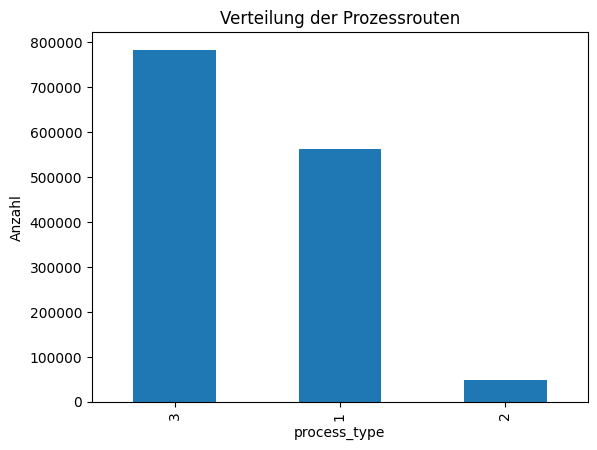

In [74]:
df_train_feat["process_type"].value_counts().plot(kind="bar")
plt.title("Verteilung der Prozessrouten")
plt.xlabel("process_type")
plt.ylabel("Anzahl")
plt.show()

In [75]:
for pt in [1,2,3]:
    subset = df_train_feat[df_train_feat["process_type"] == pt]
    print(f"\nRoute {pt} – Top AFOs:")
    print(subset["Arbeitsschrittbezeichnung"].value_counts().head(10))



Route 1 – Top AFOs:
Arbeitsschrittbezeichnung
Transport              250821
Info                    60230
Schweißen               60230
Nachschweißen           60230
End                     60230
Heften-Schweißen        60174
manuelle Nacharbeit      9900
Name: count, dtype: int64

Route 2 – Top AFOs:
Arbeitsschrittbezeichnung
Transport               19818
Info                     6606
Verputzen-Aufspannen     6606
Lackieren                6606
End                      6606
manuelle Nacharbeit      2159
Name: count, dtype: int64

Route 3 – Top AFOs:
Arbeitsschrittbezeichnung
Transport                 356160
Info                       71232
Richten                    71232
Mechanisch Bearbeiten      71232
Abspannen-Nacharbeiten     71232
End                        71232
Aufspannen                 71164
Name: count, dtype: int64


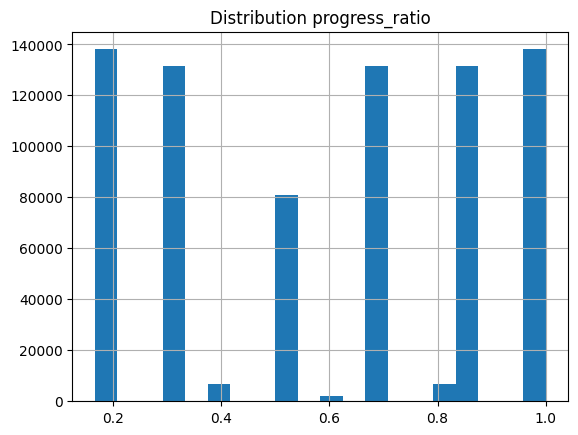

In [76]:
df_train_feat["progress_ratio"].hist(bins=20)
plt.title("Distribution progress_ratio")
plt.show()


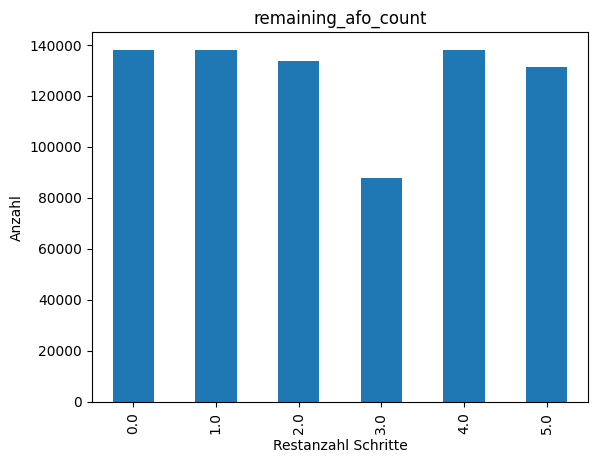

In [77]:
df_train_feat["remaining_afo_count"].value_counts().sort_index().plot(kind="bar")
plt.title("remaining_afo_count")
plt.xlabel("Restanzahl Schritte")
plt.ylabel("Anzahl")
plt.show()


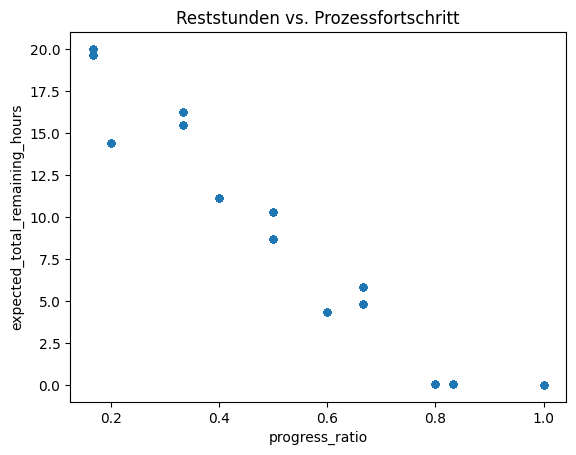

In [78]:
df_train_feat.plot.scatter(
    x="progress_ratio",
    y="expected_total_remaining_hours",
    alpha=0.3
)
plt.title("Reststunden vs. Prozessfortschritt")
plt.show()


In [79]:
df_train_feat["is_standard_sequence"].value_counts()


is_standard_sequence
1.0    766901
Name: count, dtype: int64

In [80]:
df_train_feat["possible_next_afo"].value_counts().head(20)


possible_next_afo
End                       138068
Richten                    71232
Aufspannen                 71232
Abspannen-Nacharbeiten     71232
Mechanisch Bearbeiten      71164
manuelle Nacharbeit        66780
Heften-Schweißen           60230
Nachschweißen              60230
Schweißen                   9900
Verputzen-Aufspannen        6606
Lackieren                   2159
Name: count, dtype: int64

In [82]:
df_train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393700 entries, 0 to 1393699
Data columns (total 21 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   AuftragsID                      1393700 non-null  int64         
 1   BauteilID                       1393700 non-null  int64         
 2   Bauteilbezeichnung              1393700 non-null  object        
 3   Auftragseingang                 1393700 non-null  datetime64[ns]
 4   Priorität                       1393700 non-null  int64         
 5   Auftragsende_SOLL               1393700 non-null  datetime64[ns]
 6   Arbeitsschritt                  1393700 non-null  int64         
 7   Arbeitsschrittbezeichnung       1393700 non-null  object        
 8   AFO_Start_SOLL                  1393700 non-null  datetime64[ns]
 9   AFO_Ende_SOLL                   1393700 non-null  datetime64[ns]
 10  AFO_Start_IST                   1393700 no

In [81]:
df_train_feat.to_csv('../data/processed/data_cleaned_4.csv', index=False)
df_eval_public_feat.to_csv('../data/processed/df_eval_public_v2.csv', index=False)
df_eval_private_feat.to_csv('../data/processed/df_eval_privae_v2.csv', index=False)